<a href="https://colab.research.google.com/github/felipeoliveiralps/Analise-Sentimento-Ecommerce/blob/master/notebooks/NLP/AnaliseSentimentoBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Carregando dataset já tratado**

In [3]:
import pandas as pd

dataSemStopWords = pd.read_csv('../../datasets/dataSemStopWords.csv', engine='python')


In [4]:
pip install tensorflow

**2.1 Divisão Estratificada do DataSet: Treino, Validação e Teste**

* Para preparar a modelagem, irei dividir os dados em três conjuntos: treino (80%), validação (10%) e teste (10%). Essa separação é fundamental para treinar o modelo, otimizar seus parâmetros e, por fim, realizar uma avaliação final e imparcial.

* A divisão será feita de forma estratificada utilizando a coluna feedback como base. Isso garante que a proporção de classes (positivas e negativas) seja exatamente a mesma nos três conjuntos, o que é crucial para a confiabilidade do treinamento e da avaliação do modelo.

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertForSequenceClassification, create_optimizer
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os # Para gerenciar caminhos de arquivo

seed_value = 49

os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

tf.random.set_seed(seed_value)

# Supondo que 'df' é o seu DataFrame completo com todos os dados
# Exemplo de como você poderia carregá-lo:
# df = pd.read_csv('seu_dataset_completo.csv')

# --- Passo 1: Primeira Divisão (Treino / Resto) ---
# Vamos separar 70% dos dados para o treino e deixar 30% para o "resto".
train_df, temp_df = train_test_split(
    dataSemStopWords,
    test_size=0.3,  # Define que 30% dos dados irão para o temp_df
    random_state=seed_value, # Garante que a divisão seja sempre a mesma ao rodar o código de novo
    stratify=dataSemStopWords['feedback'] # <<< ESSENCIAL para dados desbalanceados! Mantém a proporção de classes.
)

# --- Passo 2: Segunda Divisão (Validação / Teste) ---
# Agora, vamos dividir o 'temp_df' (que tem 30% do total) ao meio.
# Isso resultará em 15% do total para validação e 15% para teste.
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5, # Divide o temp_df em 50% para cada lado
    random_state=seed_value,
    stratify=temp_df['feedback'] # Estratificar aqui também é importante
)

# --- Verificação dos Tamanhos ---
print(f"Tamanho total do dataset: {len(dataSemStopWords)}")
print(f"Tamanho do conjunto de treino (train_df): {len(train_df)} (~80%)")
print(f"Tamanho do conjunto de validação (val_df): {len(val_df)} (~10%)")
print(f"Tamanho do conjunto de teste (test_df): {len(test_df)} (~10%)")

# Exemplo de como acessar os dados depois da divisão
print("\nExemplo de uma review do conjunto de treino:")
print(train_df['review_text'].iloc[0])

Tamanho total do dataset: 132373
Tamanho do conjunto de treino (train_df): 92661 (~80%)
Tamanho do conjunto de validação (val_df): 19856 (~10%)
Tamanho do conjunto de teste (test_df): 19856 (~10%)

Exemplo de uma review do conjunto de treino:
tamanho tv ótimo porem imagem péssima parece k deixou desejar muitas coisas midiacast controle funciona opção pesquisar filmes netflix controle butoes duro feio


**2.3 Carregando modelo e Tokenizer (BERTIMBAU)**
* Para esta tarefa de classificação de texto o BERTIMBAU, um modelo pré-treinado.

* A utilização de um modelo como o BERTIMBAU, em vez de treinar um do zero, nos permite transferir o "conhecimento" linguístico que ele já possui para a nossa tarefa específica. Isso resulta em um desempenho significativamente superior e um tempo de treinamento muito menor para alcançar alta acurácia.



In [6]:
model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=3)

train_df['texto_lematizado'] = train_df['texto_lematizado'].astype(str)
val_df['texto_lematizado'] = val_df['texto_lematizado'].astype(str)
test_df['texto_lematizado'] = test_df['texto_lematizado'].astype(str)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/529M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Espero 0.81 de acurácia esperada!!**

**2.4 Preparando Dados**

In [7]:
train_encodings = tokenizer(train_df['texto_lematizado'].tolist(), truncation=True, padding=True, max_length=150, return_tensors='tf')
val_encodings = tokenizer(val_df['texto_lematizado'].tolist(), truncation=True, padding=True, max_length=150, return_tensors='tf')
test_encodings = tokenizer(test_df['texto_lematizado'].tolist(), truncation=True, padding=True, max_length=150, return_tensors='tf')

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_df['feedback'].values))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_df['feedback'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_df['feedback'].values))

**2.5 Criando o peso das classes**
* Durante a análise, percebi que nosso conjunto de treino possui um desnível entre as categorias de feedback, ou seja, uma classe tem muito mais amostras que a outra. Se treinarmos o modelo com esses dados, ele pode se tornar "preguiçoso", aprendendo a prever apenas a classe majoritária e ignorando a minoritária, resultando em um desempenho ruim na prática.

* Para corrigir esse viés, irei calcular e aplicar pesos de classe. Essa técnica modifica a função de perda do modelo, aplicando uma penalidade maior quando ele comete um erro na classe minoritária.


In [8]:
y_train_labels = train_df['feedback'].values
class_labels = np.unique(y_train_labels)
class_weights_array = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train_labels)
class_weight_dict = dict(zip(class_labels, class_weights_array))

print(f"Classes: {class_labels}")
print(f"Pesos das Classes Calculados: {class_weights_array}")
print(f"Dicionário de Pesos para Keras: {class_weight_dict}")

Classes: [0 1 2]
Pesos das Classes Calculados: [1.2339499  2.70464098 0.54949297]
Dicionário de Pesos para Keras: {np.int64(0): np.float64(1.2339499021213696), np.int64(1): np.float64(2.704640980735552), np.int64(2): np.float64(0.549492972780644)}


**Configurando hiperParametros**

* Com os dados prontos, agora vou configurar os parametros para a modelagem. Irei configurar o batch_size como 16, que define quantos exemplos o modelo verá antes de atualizar seus pesos. O número de epochs será 2, o que significa que o modelo irá percorrer todo o conjunto de dados de treino duas vezes, além do learning rate scheduler com warmup.




In [9]:
batch_size = 16
epochs = 3

train_batches = train_dataset.shuffle(len(train_df), seed=seed_value, reshuffle_each_iteration=False).batch(batch_size)
val_batches = val_dataset.batch(batch_size)
test_batches = test_dataset.batch(batch_size)

steps_per_epoch = len(train_df) // batch_size
if len(train_df) % batch_size != 0:
    steps_per_epoch += 1
total_train_steps = steps_per_epoch * epochs

optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=total_train_steps,
    num_warmup_steps=int(0.1 * total_train_steps),
    weight_decay_rate=0.01
)

**Compilando Modelo!!**

In [10]:
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

**Treinando Modelo**

In [11]:
print("Iniciando o treinamento do BERTimbau com class_weight...")

history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=epochs, # Agora treina todas as 'epochs' de uma vez
    class_weight=class_weight_dict,
    # steps_per_epoch=steps_per_epoch, # Geralmente não é necessário se train_batches tem tamanho definido
    #validation_steps=len(val_df) // batch_size, # Opcional
    verbose=1
)
print("Treinamento concluído!")

Iniciando o treinamento do BERTimbau com class_weight...
Epoch 1/3
5792/5792 [==============================] - 1030s 174ms/step - loss: 0.6685 - accuracy: 0.7291 - val_loss: 0.5580 - val_accuracy: 0.7775
Epoch 2/3
5792/5792 [==============================] - 1006s 174ms/step - loss: 0.5398 - accuracy: 0.7865 - val_loss: 0.5210 - val_accuracy: 0.7938
Epoch 3/3
5792/5792 [==============================] - 1007s 174ms/step - loss: 0.4323 - accuracy: 0.8254 - val_loss: 0.5731 - val_accuracy: 0.7740
Treinamento concluído!


**Resultados**


--- Avaliação no Conjunto de Teste (modelo da última epoch) ---
1241/1241 [==============================] - 59s 47ms/step - loss: 0.5581 - accuracy: 0.7819
Loss no Teste: 0.5581
Acurácia no Teste: 78.19%
1241/1241 [==============================] - 61s 47ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

    Negativo       0.87      0.85      0.86      5364
      Neutro       0.33      0.57      0.42      2447
    Positivo       0.92      0.79      0.85     12045

    accuracy                           0.78     19856
   macro avg       0.71      0.74      0.71     19856
weighted avg       0.84      0.78      0.80     19856



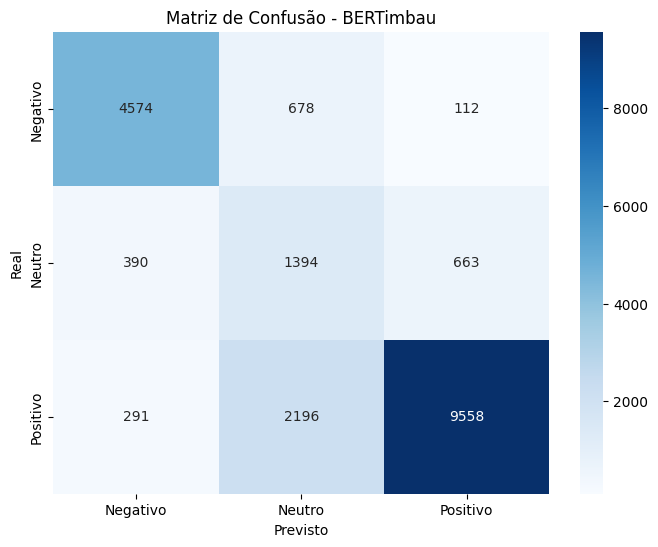

In [12]:
print("\n--- Avaliação no Conjunto de Teste (modelo da última epoch) ---")
result = model.evaluate(test_batches)
print(f"Loss no Teste: {result[0]:.4f}")
print(f"Acurácia no Teste: {result[1] * 100:.2f}%")

preds = model.predict(test_batches)
pred_classes = np.argmax(preds.logits, axis=1)

print("\nRelatório de Classificação:")
print(classification_report(
    list(test_df['feedback'].values),
    pred_classes,
    target_names=['Negativo', 'Neutro', 'Positivo']
))

cm = confusion_matrix(list(test_df['feedback'].values), pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Neutro', 'Positivo'],
            yticklabels=['Negativo', 'Neutro', 'Positivo'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - BERTimbau')
plt.show()